# Find clear scenes in high-resolution SST

### Choose a target region and time period, cycle through all available high-resolution sea surface temperature data, identify clear images, catalog them 



In [1]:
#!conda install -y -c conda-forge s3fs numpy pandas xarray matplotlib cartopy ipympl ipywidgets h5netcdf dask netCDF4 bottleneck

In [2]:
#!conda install -y -c conda-forge cartopy=0.21

In [3]:
import s3fs
import os
import os.path
import json
import warnings
import requests
import numpy as np
import pandas as pd
import xarray as xr
from io import StringIO

import sys
sys.path.append('../src')
import functions


import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker, rc, cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from cartopy.io.shapereader import Reader

warnings.filterwarnings("ignore")

# %matplotlib inline
# %matplotlib qt5
%matplotlib widget

# Define some functions

In [4]:
def plot_criterion_box(ax,**kwargs):
    """ Add a box to plots to show what box was used for the criterion.
         
    Inputs
    - matplotlib.pyplot.plot kwargs

    Return
    - exit code (True if OK)
    """

    coord = [[x1,y1], [x1,y2], [x2,y2], [x2,y1]]
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'

    xs, ys = zip(*coord) #create lists of x and y values

    if ax is None:
        ax = plt.gca()    
    # ax.plot(xs,ys,transform=ccrs.PlateCarree()) 
    ax.plot(xs,ys,**kwargs) 

    SF_lon=-(122+25/60)
    SF_lat= 37+47/60

    # mark a known place to help us geo-locate ourselves
    '''
    ax.plot(SF_lon, SF_lat, 'o', markersize=3, zorder=10, **kwargs)
    ax.text(SF_lon-5/60, SF_lat+5/60, 'San Francisco', fontsize=8, zorder=10, **kwargs)
    # ax.text(np.mean(xs)-.6, np.mean(ys)-.3, 'S-MODE ops area', fontsize=8, **kwargs)
    print(kwargs)
    '''

    return(xs,ys,ax)


In [5]:
swot_file = "../../S-MODE_analysis/data/SWOT_orbit/sph_calval_swath/swot_calval_orbit_june2015-v2_swath.shp"
nadir_file = "../../S-MODE_analysis/data/SWOT_orbit/shp_calval_nadir/swot_calval_orbit_june2015-v2_nadir.shp"
def plot_SWOT(ax):
    ax.add_geometries(Reader(swot_file).geometries(), ccrs.PlateCarree(), facecolor='white',alpha=0.15,edgecolor='k')
    ax.add_geometries(Reader(nadir_file).geometries(), ccrs.PlateCarree(), facecolor='none',linestyle='--',alpha=.5,edgecolor='k')
    return

## Set some parameters (start/end time)


In [6]:
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 400

savefig = True # set to true to save plots as file
!mkdir ../plots

__figdir__ = '../plots/'
savefig_args = {'bbox_inches':'tight', 'pad_inches':0.2}
plotfiletype='png'

mkdir: cannot create directory ‘../plots’: File exists


### Loading credentials for direct access

In [7]:
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

In [8]:
# Center location
#site = 'S-MODE'
#site = 'S-MODE IOP1'
site = 'S-MODE IOP2'
#site = 'SPURS-1'

if site == 'S-MODE':
    lon0 = -123.5
    lat0 = 37.5 
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'S-MODE IOP1':
    lon0 = -124.5
    lat0 = 37
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'S-MODE IOP2':
    lon0 = -124.5
    lat0 = 36.5
    dlon = 2.5 # half of box width in lon
    dlat = 2.0 # half of box width in lat
elif site == 'SPURS-2':
    lon0 = -125
    lat0 = 10
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-1':
    lon0 = -38
    lat0 = 25
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat

# Define the max/min lon
lon_min = lon0 - dlon
lon_max = lon0 + dlon
lat_min = lat0 - dlat
lat_max = lat0 + dlat

In [9]:
# Define a box where we want data (may be different than larger analysis domain)
# Still centered on lon0,lat0
dlon = 0.5 # half of box width in lon
dlat = 0.5 # half of box width in lat

# Define the max/min lon
x1 = lon0 - dlon
x2 = lon0 + dlon
y1 = lat0 - dlat
y2 = lat0 + dlat

In [10]:
if site == 'S-MODE':
    start_time = '2021-10-20T00:00:00Z'
    end_time = '2021-11-6T00:00:00Z'
elif site == 'S-MODE IOP1':
    start_time = '2022-10-01T00:00:00Z'#
    end_time = '2022-11-6T00:00:00Z'
elif site == 'S-MODE IOP2':
    start_time = '2021-04-01T00:00:00Z'#
    end_time = '2021-05-6T00:00:00Z'
elif site == 'SPURS-2':
    start_time = '2017-1-05T00:00:00Z'#'2016-8-20T00:00:00Z'
    end_time = '2017-11-6T00:00:00Z'
elif site == 'SPURS-1':
    start_time = '2012-12-15T00:00:00Z'#'2012-9-15T00:00:00Z'
    end_time = '2013-11-15T00:00:00Z'



Relevant VIIRS products:

https://podaac.jpl.nasa.gov/dataset/VIIRS_NPP-STAR-L3U-v2.80  
'C2147485059-POCLOUD' #VIIRS_NPP-STAR-L3U-v2.80

https://podaac.jpl.nasa.gov/dataset/VIIRS_N20-STAR-L3U-v2.80  
'C2147488020-POCLOUD' #VIIRS_N20-STAR-L3U-v2.80

# Consolidate functions

In [11]:
# Find granules matching criteria, open files in S3, return list of files that can be loaded
url = 'https://cmr.earthdata.nasa.gov/search/granules'

#concept_id = 'C2147488020-POCLOUD'; shortname= 'VIIRS_N20-STAR-L3U-v2.80'
concept_id = 'C2147485059-POCLOUD'; shortname= 'VIIRS_NPP-STAR-L3U-v2.80'

def find_S3_files(start_time,end_time):
    response = requests.get(url, 
                            params={
                                'concept_id': concept_id,
                                'temporal': start_time+','+end_time,
                                'bounding_box': '{},{},{},{}'.format(lon_min, lat_min, lon_max, lat_max),    
                                'page_size': 500,
                                },
                            headers={
                                'Accept': 'application/json'
                                }
                           )

    granules_url = []
    for gran in response.json()['feed']['entry']:
        granules_url.append(gran['links'][1]['href'])
    # granules_url
    len(granules_url)
    print('Number of files found is ' + str(len(granules_url)))
    if len(granules_url) == 500:
        print('Max number of files returned. There may be more files.  Try shortening time window.')

    # There is an inconvenient issue with these files.  The correct link is not in the same place for each of the granules.
    # The prefix should be something like:  
    # s3://podaac-ops-cumulus-protected/ 
    # and not:  
    # s3://podaac-ops-cumulus-public/
    # This is a specific kludge for these files and may not be needed always.

    granules_url2 = []
    for gran in granules_url:
        #print(gran.replace('.md5',''))
        gran2 = gran.replace('.md5','')
        #print(gran2[gran2.index('/VIIRS'):])
        granules_url2.append('s3://podaac-ops-cumulus-protected'+gran2[gran2.index('/VIIRS'):])


    file_list =  [fs.open(file) for file in granules_url2]
    return file_list

In [12]:
def plot_good_times(good_data, percent_clear):
    fig = plt.figure(figsize=(4,3),dpi=200)
    plt.plot(good_data['time'],good_data,marker='o')
    fig.autofmt_xdate()
    plt.title('1.0 indicates clear skies ('+ str(np.round(percent_clear)) + '% clear)')

    # Export figure
    if savefig:
        plt.savefig(__figdir__+'good_data_' + year_str + shortname + '.' +plotfiletype,**savefig_args)

In [13]:
def plot_SST_map(ds2, mean_SST):
    
    fig = plt.figure()
    ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-125))  # Orthographic
    extent = [lon_min, lon_max,lat_min, lat_max]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    # This string of the time of the SST selected will be useful
    day_str = np.datetime_as_string(ds2.time,unit='m')


    plt.set_cmap(cmap=plt.get_cmap('turbo')) #try turbo, nipy_spectral and gist_ncar
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title('SST, ' + day_str, size = 10.)

    # Does not do what I think it should:
    ax.minorticks_on()
    ax.tick_params(axis='both',which='both',direction='inout',top=True, right=True)

    V = mean_SST+[-1,1] #range for colorbar

    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
    cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze()-274.15,vmin=V[0],vmax=V[1],transform=ccrs.PlateCarree())
    # cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze().notnull(),transform=ccrs.PlateCarree())
    cb = plt.colorbar(cs,fraction = 0.022,extend='both')
    cb.set_label('SST [$\circ$C]',fontsize = 10)
    functions.plot_ops_area_IOP2(ax,transform=ccrs.PlateCarree(),color='k')
    plot_SWOT(ax)

    # Export figure
    if savefig:
        plt.savefig(__figdir__+'map_'  + year_str + shortname + '.' +plotfiletype,**savefig_args)

In [14]:
year_list = np.arange(2023,2024,1)
percent_clear_list = []

Processing 2023
Number of files found is 137
Files loaded...


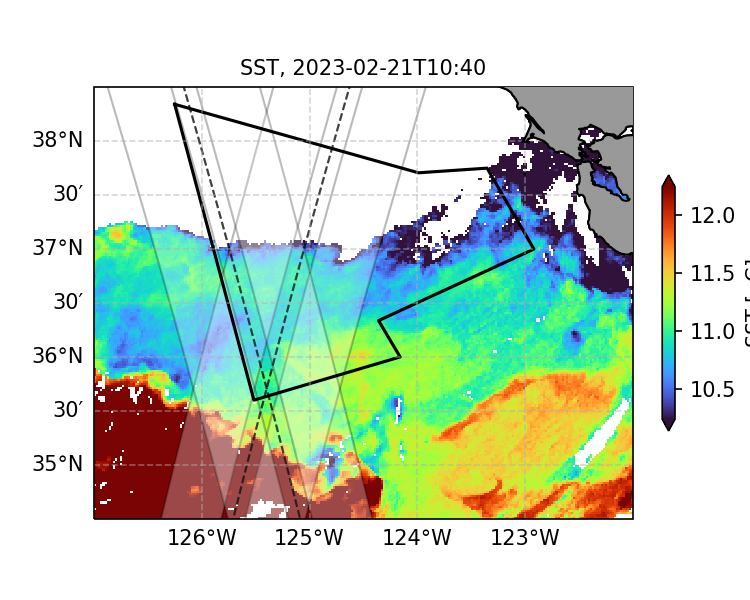

percent_clear_list = [5.109489051094891]


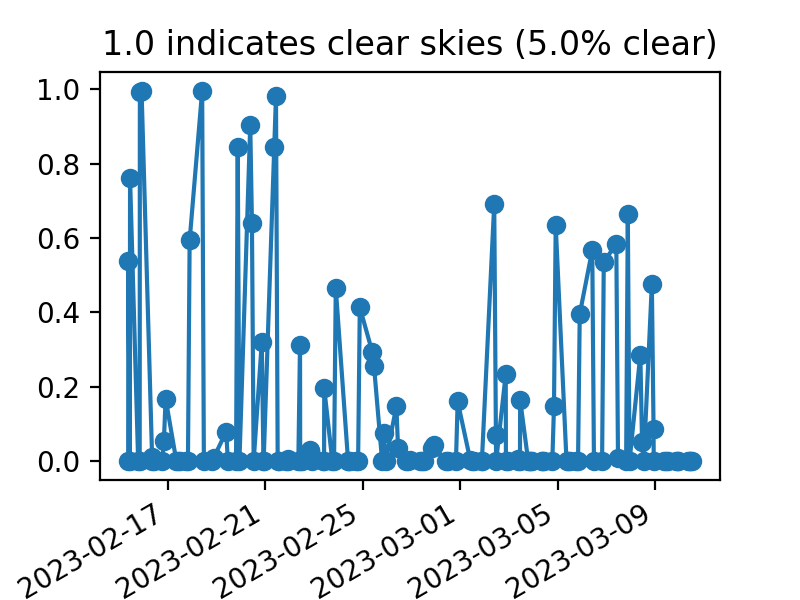

In [15]:
for ind in range(0,len(year_list)): #index for loop
    year_str = str(year_list[ind])
    print('Processing ' + year_str)
    start_time = year_str + '-02-15T00:00:00Z'#
    end_time = year_str + '-05-6T00:00:00Z'

    file_list = find_S3_files(start_time,end_time)

    ds = xr.open_mfdataset(file_list,drop_variables=['dt_analysis','satellite_zenith_angle','sses_bias','wind_speed']).sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min))
    print('Files loaded...')

    ## Make a metric to select times with clear skies in region of interest
    # The idea here is to choose a box defining region of interest and use quality flag or NaN mask to count bad/good pixels# Make a time series in that box
    # Compute mean value of "not NaN" (notnull) in the box
    good_data = ds.sea_surface_temperature.sel(lat=slice(y2,y1), lon=slice(x1,x2)).notnull().mean({'lon','lat'})
    good_times = good_data['time'].where(good_data>0.8,drop=True)
    percent_clear = 100*len(good_times)/len(good_data)
    percent_clear_list.append(percent_clear)

    plot_good_times(good_data, percent_clear)

    ## Choose a particular time
    # Find the data near this time
    d = good_times[6] # 
    ds2 = ds.sel(time=d,method='nearest')

    mean_SST = np.nanmean(ds2.sea_surface_temperature.squeeze()-274.15)

    plot_SST_map(ds2,mean_SST)
    ax = plt.gca()
    plot_SWOT(ax)
    plt.show()
    print('percent_clear_list = ' + str(percent_clear_list))

# Next steps for this script

1. make plotting functions
1. make a list of dates
1. write loop that loads ds, computes good times, makes 2 plots and saves them (maybe write ds to disk)

Maybe:  
Plot all good images.  Maybe for another script.

In [16]:
# Extract a data set with only "good times"
if 1==2:
    good_times = good_data['time'].where(good_data>0.5,drop=True)
    print(np.shape(good_times))

    d = good_times # np.datetime64('2021-11-05T00:00:00Z')
    ds3 = ds.sel(time=d,method='nearest')

    ds3

In [17]:
# Write the subsetted data set to a netcdf file
# ds3.to_netcdf('outfile.nc',format="NETCDF4")